In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks.yaml']

config = Config()

In [3]:
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
print(model.model)


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [4]:
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)

visual.blocks.0
visual.blocks.1
visual.blocks.2
visual.blocks.3
visual.blocks.4
visual.blocks.5
visual.blocks.6
visual.blocks.7
visual.blocks.8
visual.blocks.9
visual.blocks.10
visual.blocks.11
visual.blocks.12
visual.blocks.13
visual.blocks.14
visual.blocks.15
visual.blocks.16
visual.blocks.17
visual.blocks.18
visual.blocks.19
visual.blocks.20
visual.blocks.21
visual.blocks.22
visual.blocks.23
visual.blocks.24
visual.blocks.25
visual.blocks.26
visual.blocks.27
visual.blocks.28
visual.blocks.29
visual.blocks.30
visual.blocks.31
visual.merger
model.layers.0
model.layers.1
model.layers.2
model.layers.3
model.layers.4
model.layers.5
model.layers.6
model.layers.7
model.layers.8
model.layers.9
model.layers.10
model.layers.11
model.layers.12
model.layers.13
model.layers.14
model.layers.15
model.layers.16
model.layers.17
model.layers.18
model.layers.19
model.layers.20
model.layers.21
model.layers.22
model.layers.23
model.layers.24
model.layers.25
model.layers.26
model.layers.27
model.norm


In [5]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [4]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

[1020_090826] ../output/Qwen2-VL-2B-Instruct-VisualBlocks.db


In [7]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.0'}
{'layer': 'visual.blocks.1'}
{'layer': 'visual.blocks.2'}
{'layer': 'visual.blocks.3'}
{'layer': 'visual.blocks.4'}
{'layer': 'visual.blocks.5'}
{'layer': 'visual.blocks.6'}
{'layer': 'visual.blocks.7'}
{'layer': 'visual.blocks.8'}
{'layer': 'visual.blocks.9'}
{'layer': 'visual.blocks.10'}
{'layer': 'visual.blocks.11'}
{'layer': 'visual.blocks.12'}
{'layer': 'visual.blocks.13'}
{'layer': 'visual.blocks.14'}
{'layer': 'visual.blocks.15'}
{'layer': 'visual.blocks.16'}
{'layer': 'visual.blocks.17'}
{'layer': 'visual.blocks.18'}
{'layer': 'visual.blocks.19'}
{'layer': 'visual.blocks.20'}
{'layer': 'visual.blocks.21'}
{'layer': 'visual.blocks.22'}
{'layer': 'visual.blocks.23'}
{'layer': 'visual.blocks.24'}
{'layer': 'visual.blocks.25'}
{'layer': 'visual.blocks.26'}
{'layer': 'visual.blocks.27'}
{'layer': 'visual.blocks.28'}
{'layer': 'visual.blocks.29'}
{'layer': 'visual.blocks.30'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}


In [26]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 172])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': No

### For each image, calculate similarity of embeddings between pairs of layers

In [ ]:
module_names = []
module_embeddings = []
module_similarities = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)



ValueError: too many values to unpack (expected 2)

In [ ]:
# Get embeddings for each layer
for module_name, _ in tqdm(model.model.named_modules()):
    if not model.config.matches_module(module_name):
        continue
    print(module_name)
    # T
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module_name
    )
    try:
        module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)
    except Exception as e:
        print(module_name, module_embedding)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)
    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

    # Calculate similarities of pairs of images
    module_sim = db_utils.cosine_similarity_numpy(mean_embeddings, mean_embeddings)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    # Select only Upper Triangular Matrix
    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model"):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )

        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        # Compute similarity
        module_sim = db_utils.cosine_similarity_numpy(visual_mean_embeddings, visual_mean_embeddings)
        # Assert similarity is symmetric
        assert np.array_equal(module_sim, module_sim.T)

        # Select only Upper Triangular Matrix
        n_samples = module_sim.shape[0]
        ut_idxs = np.triu_indices(n_samples, k=1)
        sim_values = module_sim[ut_idxs]
        assert len(sim_values) == n_samples * (n_samples - 1) / 2

        # Store values in list
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)
        module_similarities.append(sim_values)




0it [00:00, ?it/s]

visual.blocks.0
[1020_094103] T1


7it [00:01,  6.50it/s]

[1020_094104] T2
[1020_094104] T3
[1020_094104] T4
[1020_094104] T5
visual.blocks.1
[1020_094104] T1


17it [00:02,  7.92it/s]

[1020_094105] T2
[1020_094105] T3
[1020_094105] T4
[1020_094105] T5
visual.blocks.2
[1020_094105] T1


27it [00:03,  7.71it/s]

[1020_094106] T2
[1020_094106] T3
[1020_094106] T4
[1020_094106] T5
visual.blocks.3
[1020_094106] T1


37it [00:04,  7.87it/s]

[1020_094107] T2
[1020_094107] T3
[1020_094107] T4
[1020_094107] T5
visual.blocks.4
[1020_094107] T1


47it [00:05,  8.47it/s]

[1020_094108] T2
[1020_094108] T3
[1020_094108] T4
[1020_094108] T5
visual.blocks.5
[1020_094108] T1


57it [00:06,  8.74it/s]

[1020_094109] T2
[1020_094109] T3
[1020_094109] T4
[1020_094109] T5
visual.blocks.6
[1020_094109] T1


67it [00:42,  1.27s/it]

[1020_094145] T2
[1020_094145] T3
[1020_094145] T4
[1020_094145] T5
visual.blocks.7
[1020_094145] T1


77it [01:21,  2.10s/it]

[1020_094224] T2
[1020_094224] T3
[1020_094224] T4
[1020_094224] T5
visual.blocks.8
[1020_094224] T1


87it [01:55,  2.52s/it]

[1020_094258] T2
[1020_094258] T3
[1020_094258] T4
[1020_094258] T5
visual.blocks.9
[1020_094258] T1


97it [02:39,  3.08s/it]

[1020_094342] T2
[1020_094342] T3
[1020_094342] T4
[1020_094342] T5
visual.blocks.10
[1020_094342] T1


107it [03:17,  3.31s/it]

[1020_094420] T2
[1020_094420] T3
[1020_094420] T4
[1020_094420] T5
visual.blocks.11
[1020_094420] T1


117it [03:35,  2.87s/it]

[1020_094439] T2
[1020_094439] T3
[1020_094439] T4
[1020_094439] T5
visual.blocks.12
[1020_094439] T1


127it [04:16,  3.24s/it]

[1020_094519] T2
[1020_094519] T3
[1020_094519] T4
[1020_094519] T5
visual.blocks.13
[1020_094519] T1


137it [04:32,  2.75s/it]

[1020_094536] T2
[1020_094536] T3
[1020_094536] T4
[1020_094536] T5
visual.blocks.14
[1020_094536] T1


147it [05:00,  2.74s/it]

[1020_094603] T2
[1020_094603] T3
[1020_094603] T4
[1020_094603] T5
visual.blocks.15
[1020_094603] T1


157it [05:17,  2.42s/it]

[1020_094620] T2
[1020_094620] T3
[1020_094620] T4
[1020_094620] T5
visual.blocks.16
[1020_094620] T1


167it [05:30,  2.11s/it]

[1020_094633] T2
[1020_094633] T3
[1020_094633] T4
[1020_094633] T5
visual.blocks.17
[1020_094633] T1


177it [05:44,  1.89s/it]

[1020_094647] T2
[1020_094647] T3
[1020_094647] T4
[1020_094647] T5
visual.blocks.18
[1020_094647] T1


187it [05:58,  1.73s/it]

[1020_094701] T2
[1020_094701] T3
[1020_094701] T4
[1020_094701] T5
visual.blocks.19
[1020_094701] T1


197it [06:13,  1.67s/it]

[1020_094716] T2
[1020_094716] T3
[1020_094716] T4
[1020_094716] T5
visual.blocks.20
[1020_094716] T1


207it [06:26,  1.56s/it]

[1020_094729] T2
[1020_094729] T3
[1020_094729] T4
[1020_094729] T5
visual.blocks.21
[1020_094729] T1


217it [06:42,  1.57s/it]

[1020_094745] T2
[1020_094745] T3
[1020_094745] T4
[1020_094745] T5
visual.blocks.22
[1020_094745] T1


227it [06:55,  1.48s/it]

[1020_094758] T2
[1020_094758] T3
[1020_094758] T4
[1020_094758] T5
visual.blocks.23
[1020_094758] T1


237it [07:05,  1.36s/it]

[1020_094808] T2
[1020_094808] T3
[1020_094808] T4
[1020_094808] T5
visual.blocks.24
[1020_094808] T1


247it [07:21,  1.41s/it]

[1020_094824] T2
[1020_094824] T3
[1020_094824] T4
[1020_094824] T5
visual.blocks.25
[1020_094824] T1


257it [07:34,  1.40s/it]

[1020_094838] T2
[1020_094838] T3
[1020_094838] T4
[1020_094838] T5
visual.blocks.26
[1020_094838] T1


267it [07:49,  1.41s/it]

[1020_094852] T2
[1020_094852] T3
[1020_094852] T4
[1020_094852] T5
visual.blocks.27
[1020_094852] T1


277it [08:01,  1.37s/it]

[1020_094904] T2
[1020_094904] T3
[1020_094904] T4
[1020_094904] T5
visual.blocks.28
[1020_094904] T1


287it [08:15,  1.37s/it]

[1020_094918] T2
[1020_094918] T3
[1020_094918] T4
[1020_094918] T5
visual.blocks.29
[1020_094918] T1


297it [08:29,  1.38s/it]

[1020_094932] T2
[1020_094932] T3
[1020_094932] T4
[1020_094932] T5
visual.blocks.30
[1020_094932] T1


307it [08:42,  1.35s/it]

[1020_094945] T2
[1020_094945] T3
[1020_094945] T4
[1020_094945] T5
visual.blocks.31
[1020_094945] T1


317it [08:54,  1.30s/it]

[1020_094957] T2
[1020_094957] T3
[1020_094957] T4
[1020_094957] T5
visual.merger
[1020_094957] T1


327it [08:57,  1.01s/it]

[1020_095000] T2
[1020_095000] T3
[1020_095000] T4
[1020_095000] T5
model.layers.0
[1020_095000] T1


336it [09:03,  1.12it/s]

[1020_095006] T2
[1020_095006] T3
[1020_095006] T4
[1020_095006] T5
[1020_095006] T6
[1020_095006] T7
model.layers.1
[1020_095006] T1


350it [09:06,  1.51it/s]

[1020_095010] T2
[1020_095010] T3
[1020_095010] T4
[1020_095010] T5
[1020_095010] T6
[1020_095010] T7
model.layers.2
[1020_095010] T1


364it [09:11,  1.82it/s]

[1020_095014] T2
[1020_095014] T3
[1020_095014] T4
[1020_095014] T5
[1020_095014] T6
[1020_095014] T7
model.layers.3
[1020_095014] T1


378it [09:15,  2.15it/s]

[1020_095019] T2
[1020_095019] T3
[1020_095019] T4
[1020_095019] T5
[1020_095019] T6
[1020_095019] T7
model.layers.4
[1020_095019] T1


392it [09:20,  2.33it/s]

[1020_095023] T2
[1020_095023] T3
[1020_095023] T4
[1020_095023] T5
[1020_095024] T6
[1020_095024] T7
model.layers.5
[1020_095024] T1


406it [09:25,  2.55it/s]

[1020_095028] T2
[1020_095028] T3
[1020_095028] T4
[1020_095028] T5
[1020_095028] T6
[1020_095028] T7
model.layers.6
[1020_095028] T1


420it [09:30,  2.60it/s]

[1020_095033] T2
[1020_095033] T3
[1020_095033] T4
[1020_095033] T5
[1020_095033] T6
[1020_095033] T7
model.layers.7
[1020_095033] T1


434it [09:34,  2.91it/s]

[1020_095037] T2
[1020_095037] T3
[1020_095037] T4
[1020_095037] T5
[1020_095037] T6
[1020_095037] T7
model.layers.8
[1020_095037] T1


448it [09:38,  2.94it/s]

[1020_095041] T2
[1020_095041] T3
[1020_095041] T4
[1020_095041] T5
[1020_095041] T6
[1020_095041] T7
model.layers.9
[1020_095041] T1


462it [09:42,  3.09it/s]

[1020_095045] T2
[1020_095045] T3
[1020_095045] T4
[1020_095045] T5
[1020_095045] T6
[1020_095045] T7
model.layers.10
[1020_095045] T1


476it [09:47,  2.98it/s]

[1020_095050] T2
[1020_095050] T3
[1020_095050] T4
[1020_095050] T5
[1020_095050] T6
[1020_095050] T7
model.layers.11
[1020_095050] T1


490it [09:52,  3.06it/s]

[1020_095055] T2
[1020_095055] T3
[1020_095055] T4
[1020_095055] T5
[1020_095055] T6
[1020_095055] T7
model.layers.12
[1020_095055] T1


504it [09:57,  2.84it/s]

[1020_095100] T2
[1020_095100] T3
[1020_095100] T4
[1020_095100] T5
[1020_095100] T6
[1020_095100] T7
model.layers.13
[1020_095100] T1


518it [10:02,  2.91it/s]

[1020_095105] T2
[1020_095105] T3
[1020_095105] T4
[1020_095105] T5
[1020_095105] T6
[1020_095105] T7
model.layers.14
[1020_095105] T1


532it [10:07,  2.89it/s]

[1020_095110] T2
[1020_095110] T3
[1020_095110] T4
[1020_095110] T5
[1020_095110] T6
[1020_095110] T7
model.layers.15
[1020_095110] T1


546it [10:11,  2.95it/s]

[1020_095114] T2
[1020_095114] T3
[1020_095114] T4
[1020_095114] T5
[1020_095114] T6
[1020_095114] T7
model.layers.16
[1020_095114] T1


560it [10:16,  2.88it/s]

[1020_095119] T2
[1020_095119] T3
[1020_095119] T4
[1020_095119] T5
[1020_095119] T6
[1020_095119] T7
model.layers.17
[1020_095119] T1


574it [10:20,  3.09it/s]

[1020_095123] T2
[1020_095123] T3
[1020_095123] T4
[1020_095123] T5
[1020_095123] T6
[1020_095123] T7
model.layers.18
[1020_095123] T1


588it [10:26,  2.89it/s]

[1020_095129] T2
[1020_095129] T3
[1020_095129] T4
[1020_095129] T5
[1020_095129] T6
[1020_095129] T7
model.layers.19
[1020_095129] T1


602it [10:30,  2.97it/s]

[1020_095133] T2
[1020_095133] T3
[1020_095133] T4
[1020_095133] T5
[1020_095133] T6
[1020_095133] T7
model.layers.20
[1020_095133] T1


616it [10:35,  2.88it/s]

[1020_095138] T2
[1020_095138] T3
[1020_095138] T4
[1020_095138] T5
[1020_095138] T6
[1020_095138] T7
model.layers.21
[1020_095138] T1


630it [10:41,  2.79it/s]

[1020_095144] T2
[1020_095144] T3
[1020_095144] T4
[1020_095144] T5
[1020_095144] T6
[1020_095144] T7
model.layers.22
[1020_095144] T1


644it [10:46,  2.81it/s]

[1020_095149] T2
[1020_095149] T3
[1020_095149] T4
[1020_095149] T5
[1020_095149] T6
[1020_095149] T7
model.layers.23
[1020_095149] T1


658it [10:50,  3.00it/s]

[1020_095153] T2
[1020_095153] T3
[1020_095153] T4
[1020_095153] T5
[1020_095153] T6
[1020_095153] T7
model.layers.24
[1020_095153] T1


672it [10:55,  2.83it/s]

[1020_095158] T2
[1020_095158] T3
[1020_095158] T4
[1020_095158] T5
[1020_095158] T6
[1020_095158] T7
model.layers.25
[1020_095158] T1


686it [10:59,  2.98it/s]

[1020_095202] T2
[1020_095202] T3
[1020_095202] T4
[1020_095202] T5
[1020_095202] T6
[1020_095202] T7
model.layers.26
[1020_095202] T1


700it [11:08,  2.34it/s]

[1020_095211] T2
[1020_095211] T3
[1020_095211] T4
[1020_095211] T5
[1020_095211] T6
[1020_095211] T7
model.layers.27
[1020_095211] T1


714it [11:14,  2.40it/s]

[1020_095217] T2
[1020_095217] T3
[1020_095217] T4
[1020_095217] T5
[1020_095217] T6
[1020_095217] T7
model.norm
[1020_095217] T1


730it [11:15,  1.08it/s]

[1020_095218] T2
[1020_095218] T3
[1020_095218] T4
[1020_095218] T5
[1020_095218] T6
[1020_095218] T7


In [ ]:
# module_names = module_names[7:]
# module_embeddings = module_embeddings[7:]
# module_similarities = module_similarities[7:]

# print(len(module_names))

91


91
0 visual.blocks.0
1 visual.blocks.1
2 visual.blocks.2
3 visual.blocks.3
4 visual.blocks.4
5 visual.blocks.5
6 visual.blocks.6
7 visual.blocks.7
8 visual.blocks.8
9 visual.blocks.9
10 visual.blocks.10
11 visual.blocks.11
12 visual.blocks.12
13 visual.blocks.13
14 visual.blocks.14
15 visual.blocks.15
16 visual.blocks.16
17 visual.blocks.17
18 visual.blocks.18
19 visual.blocks.19
20 visual.blocks.20
21 visual.blocks.21
22 visual.blocks.22
23 visual.blocks.23
24 visual.blocks.24
25 visual.blocks.25
26 visual.blocks.26
27 visual.blocks.27
28 visual.blocks.28
29 visual.blocks.29
30 visual.blocks.30
31 visual.blocks.31
32 visual.merger
33 model.layers.0
34 model.layers.0-visual
35 model.layers.1
36 model.layers.1-visual
37 model.layers.2
38 model.layers.2-visual
39 model.layers.3
40 model.layers.3-visual
41 model.layers.4
42 model.layers.4-visual
43 model.layers.5
44 model.layers.5-visual
45 model.layers.6
46 model.layers.6-visual
47 model.layers.7
48 model.layers.7-visual
49 model.layers.

<Figure size 640x480 with 0 Axes>

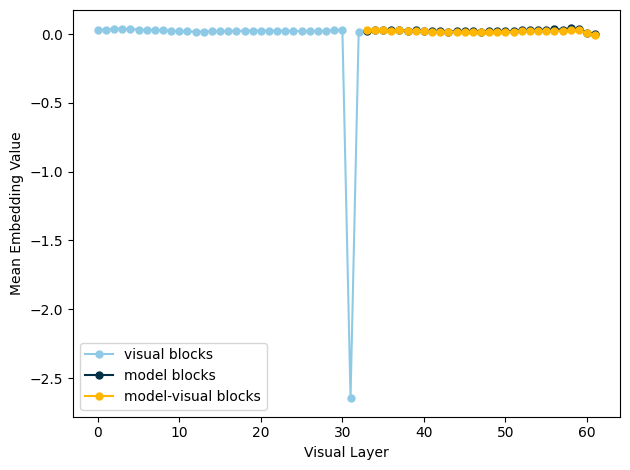

<Figure size 640x480 with 0 Axes>

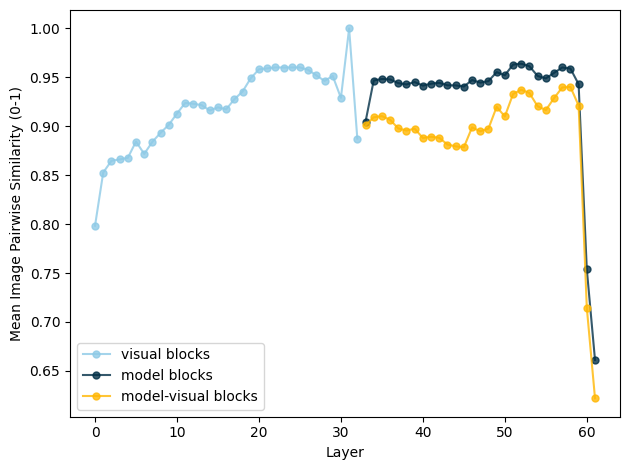

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Mean Image Pairwise Similarity (0-1)'>)

In [ ]:
# For each layer, calculate the mean similarity and the norm
mean_embeddings = {}
mean_similarities = {}
print(len(module_names))
for idx, (name, embs, sims) in enumerate(zip(module_names, module_embeddings, module_similarities)):
    # if idx < 4:
    #     continue
    print(idx, name)
    key = name.split(".")[0]
    if key == "model":
        if "visual" in name:
            key += "-visual"
    if key in mean_embeddings:
        mean_embeddings[key].append(np.mean(embs))
    else:
        mean_embeddings[key] = [np.mean(embs)]

    if key in mean_similarities:
        mean_similarities[key].append(np.mean(sims))
    else:
        mean_similarities[key] = [np.mean(sims)]

# Plot mean embeddings
xs = []
ys = []
labels = []

n_vision_layers = len(mean_embeddings["visual"])
n_items = 0
for k, v in mean_embeddings.items():
    if k.startswith("model"):
        xs.append([i + n_vision_layers for i in range(len(v))])
    else:
        xs.append([i for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))

print(len(ys[0]))
visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    xlabel='Visual Layer',
    ylabel='Mean Embedding Value',
    show=True
)

xs = []
ys = []
labels = []
n_items = 0
for k, v in mean_similarities.items():
    if k.startswith("model"):
        xs.append([i + n_vision_layers for i in range(len(v))])
    else:
        xs.append([i for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))

visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    alpha=0.8,
    xlabel='Layer',
    ylabel='Mean Image Pairwise Similarity (0-1)',
    show=True
)


In [ ]:
layer_names = ["model.layers.{}".format(i) for i in range(28)]
layer_names += ["model.norm"]
m_names, m_embeddings, m_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=layer_names,
    modalities=['vision', "text+vision"])

model.layers.0
vision 0.9028096695025924
text+vision 0.9064101371180364
model.layers.1
vision 0.9110226349841211
text+vision 0.9478352979445779
model.layers.2
vision 0.9121672156845696
text+vision 0.949389299333003
model.layers.3
vision 0.9084619801878223
text+vision 0.9488885157704939
model.layers.4
vision 0.8998475850997214
text+vision 0.9452293385094176
model.layers.5
vision 0.8977214285623358
text+vision 0.9439133728448894
model.layers.6
vision 0.8995922185533461
text+vision 0.9462976948605567
model.layers.7
vision 0.890279719823685
text+vision 0.9427188427011585
model.layers.8


91
0 model.layers.27-vision
1 model.layers.27
2 model.norm-vision
3 model.norm
[[np.float64(0.7145373185464724), np.float64(0.6219949077797956)], [np.float64(0.7538486586090226), np.float64(0.6611800639575248)]]


<Figure size 640x480 with 0 Axes>

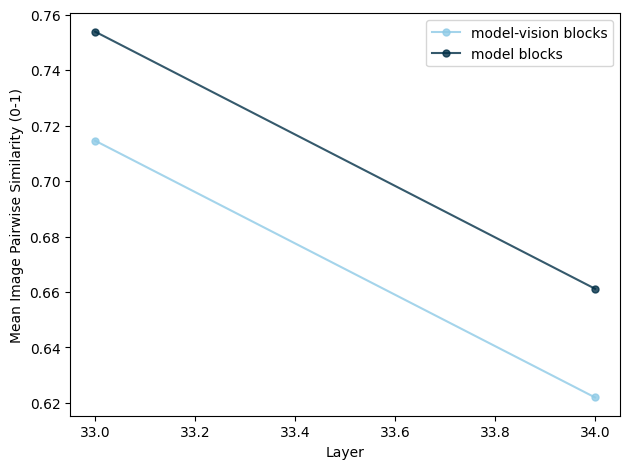

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Mean Image Pairwise Similarity (0-1)'>)

In [69]:
# For each layer, calculate the mean similarity and the norm
mean_embeddings = {}
mean_similarities = {}
print(len(module_names))
for idx, (name, embs, sims) in enumerate(zip(m_names, m_embeddings, m_similarities)):
    # if idx < 4:
    #     continue
    print(idx, name)
    key = name.split(".")[0]
    if "-" in name:
        key += "-{}".format(name.split("-")[1])
    # if key == "model":
    #     if "text+vision" in name:
    #         key += "-visual"
    if key in mean_embeddings:
        mean_embeddings[key].append(np.mean(embs))
    else:
        mean_embeddings[key] = [np.mean(embs)]

    if key in mean_similarities:
        mean_similarities[key].append(np.mean(sims))
    else:
        mean_similarities[key] = [np.mean(sims)]

# Plot mean image-pair similarity scores by layer
xs = []
ys = []
labels = []
n_items = 0
for k, v in mean_similarities.items():
    if k.startswith("model"):
        xs.append([i + n_vision_layers for i in range(len(v))])
    else:
        xs.append([i for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))

print(ys)
visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    alpha=0.8,
    xlabel='Layer',
    ylabel='Mean Image Pairwise Similarity (0-1)',
    show=True
)
